# Rookie 5 Year Predictions

#### Seraj, Isaac, and Chris

![](images/bball_bg.jpg)

## Overview

We will be using various classification models to best predict a binary target using a NBA Player Statistics dataset, specifically to predict whether or not their career duration was over 5 years.

### Business Problem

Classify which NBA players to keep based on their stats of their first season (5-years)

Our goal is to help NBA front offices make better informed personnel decisions on their rookie players based on the historical data of NBA rookies from 1980 to 2012. These personnel decisions include but are not limited to, contract extensions, trading players, and/or releasing players from their contracts
	Context → average NBA career is 4.5 to 4.8 years, NBA rookie contracts are 4 years in total so many draftees in the first round are expected to be able to contributors (exceptions for very young players and foreign players)

Further explanation: 
(based on a rookie’s stats, which specific stats are most predictive of having an NBA career longer than 5 years?)



### Stakeholders

NBA front offices

Specifically, NBA general managers can find this useful because these are the people in charge of team operations and personnel. They hold the ability to trade, release, and sign players in free agency or to contract extensions. A player’s length of career is not solely decided by the stats of his rookie season, but this insight can help GMs get a better picture of which players have a better chance of “sticking” in the league than others.


## Data

We have used two datasets to make our predictive models, 'nba-players.csv' from Kaggle and 'NBA Rookies by Year.xlsx' from DataWorld. We concatted both dataset together to get the full array of statistics we were interested in exploring and saved it as nba.csv. Features are completely performance based and does not include some features that may lead to bias, such as Race. All features are an average per game statistic except for name(Player Name), gp(Games Played), target_5yrs(Career Duration > 5 Years), and Year Drafted. The dataframe column and descriptions are listed below:

| Columns | Descriptions |
| --- | --- |
| name | Player Name |
| gp | Games played |
| min | Minutes Played |
| pts | Points per Game |
| fgm | Field Goals made |
| fga | Field Goal Attempts |
| fg | Field Goal Percentage |
| 3p_made | 3 Points made |
| 3pa | 3 Point Attempts |
| 3p | 3 Point Percentage |
| ftm | Free Throw made |
| fta | Free Throw Attempts |
| ft | Free Throw Percentage |
| oreb | Offensive Rebounds |
| dreb | Defensive Rebounds |
| reb | Rebounds |
| ast | Assists |
| stl |Steals |
| blk | Blocks |
| tov | Turnovers |
| target_5yrs | Career Duration > 5 years|
| Year Drafted | Year Drafted |

## Data Preparation

### Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Dataset/nba.csv', index_col=0)

### Helper Functions

### Dropping Unnecessary Features

In [3]:
# dropping duplicate names
df.drop_duplicates(subset='name', keep=False, inplace=True)

In [4]:
df = df[df['Year Drafted'] < 2013]

In [5]:
df.corr()['target_5yrs'].sort_values()

Year Drafted    0.039984
3p              0.050384
3pa             0.113384
3p_made         0.117835
ft              0.139435
ast             0.214056
fg              0.220020
blk             0.236490
stl             0.279787
oreb            0.292800
tov             0.296483
fta             0.312414
ftm             0.316961
fga             0.327840
reb             0.345065
fgm             0.350570
pts             0.352239
dreb            0.354961
min             0.380277
gp              0.409866
target_5yrs     1.000000
Name: target_5yrs, dtype: float64

In [6]:
df['target_5yrs'].value_counts(normalize=True)

1    0.677074
0    0.322926
Name: target_5yrs, dtype: float64

In [7]:
df = df.drop(['name','fgm','fga','3p_made','3pa','ftm','fta','oreb','dreb','Year Drafted'], axis=1)

## Modeling

### Helper Functions

# Model 1 - Baseline Decision Tree
### For our baseline model, we decided to implement a decision tree and used field goal percentage (ft) as our feature. We chose to go with a percentage because statistics like games played, points per game, and minutes per game contain bias. This is because not every rookie's situation is the same when they come into the league. High draft picks (ex. 1-5 overall) usually have different roles to their team than players drafted (20-30 overall). Field goal percentage is a measure of a player's efficiency because it measures how many total shots they made (excluding free throws) divided by the total amount of shots they took (excluding free throws. 

In [8]:
X = df[['fg']]
y = df['target_5yrs']

#### Splitting into training, validation, and test set; Test set will be used at the very end of our modeling process and fit to our best performing model

In [9]:


# first, split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# splitting the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [10]:
base_tree = DecisionTreeClassifier(random_state=42)

In [11]:
base_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
tree_preds = base_tree.predict(X_val)

In [13]:
print(classification_report(y_val, tree_preds))

              precision    recall  f1-score   support

           0       0.36      0.32      0.34        74
           1       0.68      0.72      0.70       150

    accuracy                           0.59       224
   macro avg       0.52      0.52      0.52       224
weighted avg       0.58      0.59      0.58       224



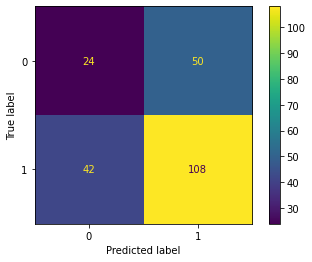

In [14]:
plot_confusion_matrix(base_tree,X_val,y_val)

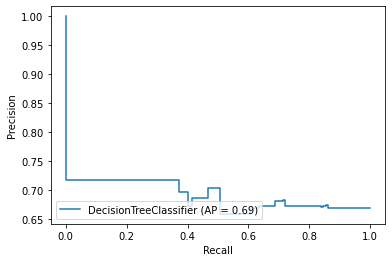

In [15]:
plot_precision_recall_curve(base_tree, X_val, y_val )

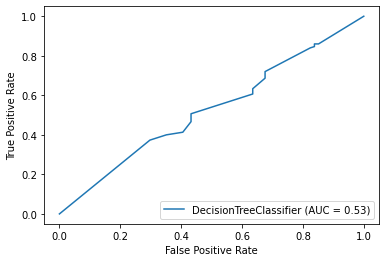

In [16]:
plot_roc_curve(base_tree,X_val,y_val)

#### Interpreting the Baseline Model

## Train | Test Split (all features)

In [17]:
# split into X and y
X = df.drop('target_5yrs', axis=1)
y = df['target_5yrs']

In [18]:
# first, split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# splitting the training data into training and validation data\n",
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Model 1- Logistic Regression

### LG Pipeline

In [19]:
log = LogisticRegression()
# scaler object
scaler = StandardScaler()
# knn operations
log_operations = [('scaler', scaler), ('log', log)]
# import pipeline object
log_pipe = Pipeline(log_operations)

In [20]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('log', LogisticRegression())])

In [21]:
log_pred = log_pipe.predict(X_val)

In [22]:
print(classification_report(y_val, log_pred))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53        74
           1       0.77      0.85      0.81       150

    accuracy                           0.73       224
   macro avg       0.69      0.66      0.67       224
weighted avg       0.72      0.73      0.72       224



# Model 2 - K-Nearest Neighbors

### KNN Pipeline

In [23]:
knn = KNeighborsClassifier()
# knn operations
knn_operations = [('scaler', scaler), ('knn', knn)]
# import pipeline object
knn_pipe = Pipeline(knn_operations)


In [24]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [25]:
knn_pred = knn_pipe.predict(X_val)

In [26]:
print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.53      0.43      0.48        74
           1       0.74      0.81      0.78       150

    accuracy                           0.69       224
   macro avg       0.64      0.62      0.63       224
weighted avg       0.67      0.69      0.68       224



# Model 3 - Decision Tree

In [27]:
dtc = DecisionTreeClassifier()

In [28]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [29]:
dtc_pred = dtc.predict(X_val)

In [30]:
print(classification_report(y_val, dtc_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        74
           1       0.77      0.77      0.77       150

    accuracy                           0.69       224
   macro avg       0.65      0.65      0.65       224
weighted avg       0.69      0.69      0.69       224



# Model 4 - Random Forest

In [31]:
rfc_model = RandomForestClassifier(n_estimators=10,
                                  max_features='auto',)

In [32]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [33]:
rfc_preds = rfc_model.predict(X_val)

In [34]:
print(classification_report(y_val, rfc_preds))

              precision    recall  f1-score   support

           0       0.52      0.54      0.53        74
           1       0.77      0.75      0.76       150

    accuracy                           0.68       224
   macro avg       0.64      0.65      0.65       224
weighted avg       0.69      0.68      0.68       224



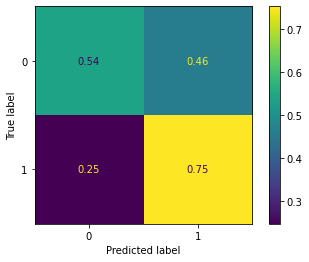

In [35]:
plot_confusion_matrix(rfc_model, X_val, y_val, normalize='true')

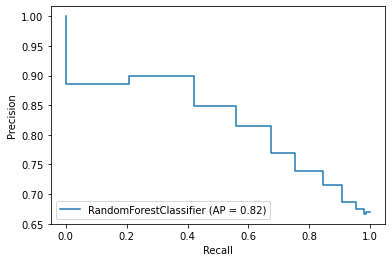

In [36]:
plot_precision_recall_curve(rfc_model, X_val, y_val )

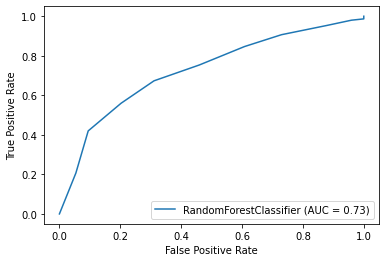

In [37]:
plot_roc_curve(rfc_model,X_val,y_val)

# Model 5 - XGBoost

In [38]:
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [39]:
xgb1_preds = xgb1.predict(X_val)

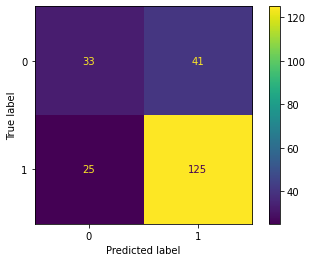

In [40]:
plot_confusion_matrix(xgb1, X_val, y_val)

In [41]:
print(classification_report(y_val, xgb1_preds))

              precision    recall  f1-score   support

           0       0.57      0.45      0.50        74
           1       0.75      0.83      0.79       150

    accuracy                           0.71       224
   macro avg       0.66      0.64      0.65       224
weighted avg       0.69      0.71      0.69       224



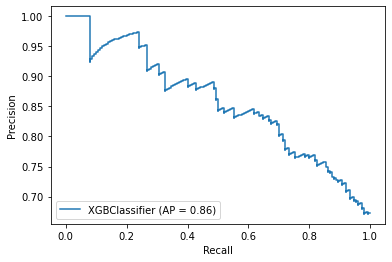

In [42]:
plot_precision_recall_curve(xgb1, X_val, y_val )

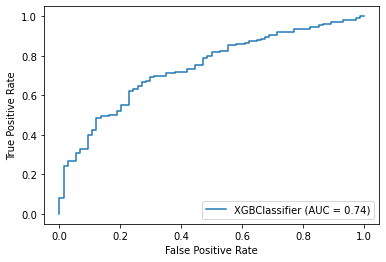

In [43]:
plot_roc_curve(xgb1,X_val,y_val)

# Model 6 - Hyper-parameter Optimized XGBoost

In [44]:
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [45]:
param_grid_xgb2 = {
    'learning_rate': [0.1, 0.2,0.3],
    'gamma' : [0,1,2,3],
    'max_depth': [1,2,3],
    'min_child_weight': [1,2,3],
    'subsample': [0.5, 0.7],
    'n_estimators': [10,50,100],
}

In [46]:
grid_xgb2 = GridSearchCV(xgb2, param_grid_xgb2, scoring='accuracy',n_jobs=1, cv=3)

In [47]:
grid_xgb2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=False,
                    

In [48]:
grid_xgb2.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 1,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.7}

In [49]:
training_preds = grid_xgb2.predict(X_train)
val_preds = grid_xgb2.predict(X_val)

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_val, val_preds)

In [50]:
print(training_accuracy)
print(val_accuracy)

0.7678571428571429
0.7098214285714286


# Final - Feature Optimized XGBoost

### Final Model

In [64]:
X= df[['gp','pts','reb','blk']]
y= df['target_5yrs']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# splitting the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [66]:
xgb3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [67]:
param_grid_xgb3 = {
    'learning_rate': [0.1, 0.2,0.3],
    'gamma' : [0,1,2,3],
    'max_depth': [1,2,3],
    'min_child_weight': [1, 2,3],
    'subsample': [0.5, 0.7],
    'n_estimators': [10,50,100],
}

In [68]:
grid_xgb3 = GridSearchCV(xgb3, param_grid_xgb3, scoring='accuracy',n_jobs=1, cv=3)

In [ ]:
grid_xgb3.fit(X_train, y_train)

In [ ]:
grid_xgb3.best_params_

In [ ]:
training_preds = grid_xgb3.predict(X_train)
val_preds = grid_xgb3.predict(X_val)

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_val, val_preds)

In [ ]:
print(training_accuracy)
print(val_accuracy)

In [ ]:
plot_confusion_matrix(grid_xgb3, X_val, y_val)

In [63]:
print(classification_report(y_val, val_preds))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47        74
           1       0.74      0.80      0.77       150

    accuracy                           0.68       224
   macro avg       0.63      0.62      0.62       224
weighted avg       0.67      0.68      0.67       224



## Conclusion

In [ ]:
log2 = LogisticRegression()
# scaler object
scaler = StandardScaler()
# knn operations
log2_operations = [('scaler', scaler), ('log2', log2)]
# import pipeline object
log2_pipe = Pipeline(log2_operations)

In [ ]:
param_grid_log2 = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [ ]:
grid_log2 = GridSearchCV(log2, param_grid_log2, scoring='accuracy',n_jobs=1, cv=3)

In [ ]:
log2_pipe.fit(X_train, y_train)

In [ ]:
grid_log2.best_params_

In [ ]:
training_preds = grid_log2.predict(X_train)
val_preds = grid_log2.predict(X_val)

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_val, val_preds)

In [ ]:
print(training_accuracy)
print(val_accuracy)

In [ ]:
plot_confusion_matrix(log2, X_val, y_val)

In [ ]:
print(classification_report(y_val, log2_preds))